In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('EURUSDnew.csv',header=None)
dataset_train.columns = ['Date','Time','Open','High','Low','Close','Volume']

In [3]:
dataset_train.shape

(12578, 7)

In [4]:
dataset_train.tail()



,Date,Time,Open,High,Low,Close,Volume
12573,2021.02.12,00:00,1.21303,1.21444,1.20815,1.21437,55238
12574,2021.02.18,00:00,1.20627,1.20941,1.20616,1.20920,59078
12575,2021.02.19,00:00,1.20878,1.21439,1.20816,1.21172,79934
12576,2021.02.22,00:00,1.21123,1.21689,1.20904,1.21572,85015
12577,2021.02.23,00:00,1.21541,1.21765,1.21539,1.21696,10056


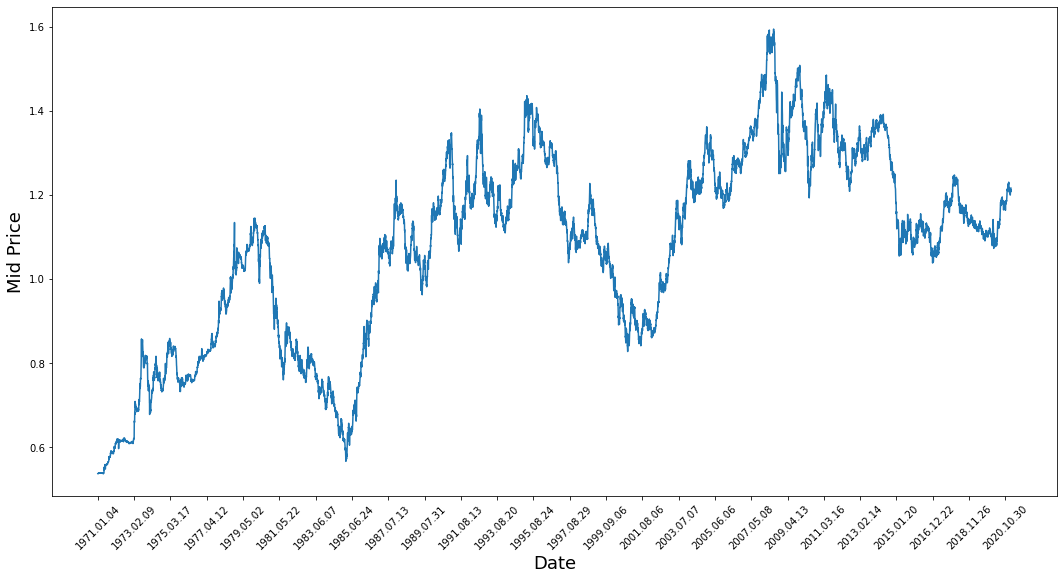

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(dataset_train.shape[0]),(dataset_train['Low']+dataset_train['High'])/2.0)
plt.xticks(range(0,dataset_train.shape[0],500),dataset_train['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [6]:
PlotDf = dataset_train[['Date','Open']]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(dataset_train.Open.values.reshape(-1, 1))

In [9]:
stock_prices =stock_prices.astype('float32')


stock_prices = stock_prices.reshape(dataset_train.shape[0], 1)

In [15]:
from numpy import array

def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.values
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [16]:
X,y = to_supervised(pd.DataFrame(stock_prices),10,5)

In [17]:
X = np.reshape(X, (X.shape[0],X.shape[1], 1 ))

In [18]:
X.shape

(12564, 10, 1)

In [19]:
y.shape

(12564, 5)

In [22]:
length =50
output = 5

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 20)            1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
model.fit(X, y, batch_size=32, epochs=200)

Epoch 1/200
393/393 [==============================] - 8s 8ms/step - loss: 0.1369
Epoch 2/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0151
Epoch 3/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0135
Epoch 4/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0132
Epoch 5/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0131
Epoch 6/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0124
Epoch 7/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0120
Epoch 8/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0118
Epoch 9/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0113
Epoch 10/200
393/393 [==============================] - 4s 10ms/step - loss: 0.0111
Epoch 11/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0111
Epoch 12/200
393/393 [==============================] - 4s 11ms/step - loss: 0.0110
Epoch 13/20

393/393 [==============================] - 3s 9ms/step - loss: 0.0083
Epoch 92/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0083
Epoch 93/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0082
Epoch 94/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0083
Epoch 95/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0085
Epoch 96/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0084
Epoch 97/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0082
Epoch 98/200
393/393 [==============================] - 4s 10ms/step - loss: 0.0083
Epoch 99/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0084
Epoch 100/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0083
Epoch 101/200
393/393 [==============================] - 3s 9ms/step - loss: 0.0084
Epoch 102/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 103/200

393/393 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 189/200
393/393 [==============================] - 4s 9ms/step - loss: 0.0083
Epoch 190/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 191/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 192/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 193/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 194/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 195/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 196/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 197/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0082
Epoch 198/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0081
Epoch 199/200
393/393 [==============================] - 3s 8ms/step - loss: 0.0083
Epoch 

In [24]:
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

MAE: 0.008126


In [25]:
TestObservation = dataset_train.Open.tail(10).values
TestObservation = TestObservation.reshape(1,10,1)
model.predict(TestObservation)

array([[1.2040479, 1.2014096, 1.2013907, 1.2011492, 1.1991037]],
      dtype=float32)

In [26]:
model.predict(TestObservation).reshape(-1,1)

array([[1.2040479],
       [1.2014096],
       [1.2013907],
       [1.2011492],
       [1.1991037]], dtype=float32)

In [27]:
dataset_train.Date[len(dataset_train.Date)-1]

'2021.02.23'

In [28]:
OP = pd.DataFrame({'Date':pd.date_range(dataset_train.Date[len(dataset_train.Date) -1], periods=6).tolist()})

In [29]:
OP = OP.iloc[1:,]

In [30]:
OP['Prediction'] = model.predict(TestObservation).reshape(-1,1)

In [31]:
OP = pd.concat([PlotDf,OP],axis=0)

In [32]:
OP.set_index('Date', inplace=True)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text major ticklabel objects>)

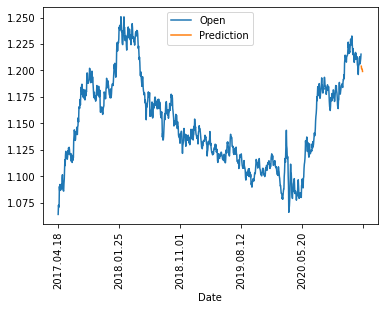

In [33]:
OP.tail(1000).plot()
plt.xticks(rotation=90)

In [34]:
OP.tail(15)

,Open,Prediction
Date,,
2021.02.05,1.19618,NaN
2021.02.08,1.20426,NaN
2021.02.09,1.20493,NaN
2021.02.10,1.21173,NaN
2021.02.11,1.21172,NaN
2021.02.12,1.21303,NaN
2021.02.18,1.20627,NaN
2021.02.19,1.20878,NaN
2021.02.22,1.21123,NaN
